# **Assignment 3**

### **Collaborators**: Francesco Emanuele Conti, Gabriele Musso,  Liang Kunyang, Yao Yanyin

##### **Introduction**
We were assigned, in collaboration between the University of Palermo and the University of Bourgogne, to tackle the issue of image restoration in order to reduce noise present in corrupted images. The objective is to characterize the type of noise present in each sample, develop a sequence of appropriate image processing steps to mitigate it, and utilize a Markov Random Field (MRF) model for image denoising.


##### **Followed Procedures**

1. **Noise Characterization**: To characterize the type of noise present in the image, we will analyze the histogram of grayscale levels in constant areas of the image and deduce the type of noise. By examining the histogram, we can gain insights into the type of noise, such as whether it is Gaussian noise, salt-and-pepper noise, or Poisson noise. Additionally, we will estimate the noise parameters to be utilized in subsequent image processing stages.

2. **Noise Reduction**: To reduce image noise, we will select a spatial filtering technique or implement an adaptive filter. Motivated implementation choices will be made to select the most appropriate filtering technique. Spatial filtering techniques may include linear filters such as the mean filter, median filter, or Gaussian filter. We will also consider the use of adaptive filters that can adapt to the local characteristics of the image for better noise reduction.

3. **Denoising using MRF**: We will utilize the iterated conditional modes (ICM) algorithm to fit a Markov Random Field (MRF) model and obtain the denoised grayscale image. ICM is an optimization algorithm that alternates between estimating pixel values and estimating MRF parameters to achieve a better reconstruction of the original image. We will implement the ICM algorithm tailored to our specific requirements for denoising the image.

##### **Task 1**: Noise Characterization
To address the task of noise characterization in the image, we will follow the following steps:

1. **Selection of a uniform intensity section**: We will choose a portion of the image where the pixel intensity is as uniform as possible. This will allow us to focus on the type of noise affecting the image without being influenced by significant variations in the image content.

2. **Calculation of the histogram**: Once the image section is selected, we will calculate the histogram of the grayscale levels present. The histogram will provide a visual representation of the distribution of pixel values in the selected section.

3. **Comparison with known noise distributions**: We will compare the obtained histogram with major known noise distributions, such as Gaussian distribution, salt-and-pepper distribution, and Poisson distribution. We will analyze the shape of the histogram and look for matches with typical characteristics of each noise distribution.

4. **Estimation of noise parameters**: If we identify the type of noise present in the image, we will estimate the corresponding parameters. For example, in the case of Gaussian noise, we might calculate the mean and standard deviation of the pixel values in the selected section.

In [1]:
# Import the necessary libraries
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import os
import csv
import time

In [2]:
# this dictionary contain for each image_name the section (x,y, width, height) 
# considered for the histogram
img_dictionary =    {      
                        'R8' : (207,48,105,30),
                        'R30': (67, 23, 112, 16),
                        'R34': (365, 62, 131, 41),
                        'R39': (80, 93, 92, 23),
                        'R51': (443, 129, 47, 102),
                        'R67': (179, 464, 69, 32),
                        'R84': (37, 322, 148, 29),
                        'R85': (223, 34, 154, 30),
                        'R95': (53, 525, 65, 22),
                        'R101': (81, 399, 41, 10)
                    }

In [3]:

def task1_NoiseCharacterizer():

    # This method takes in input a dir_path and returns a dictionary with key = image_path and as value the name of the image.
    def getFiles(dir_path):
        '''
            This method takes in input a dir_path and returns a dictionary
            containing the images's path and their names.

            Args:
                dir_path: directory path of the images.
            
            Returns:
                filespath:  A dictionary containing as key the path to the image
                            and as value the name of the image without extension.

        '''
        filespath = {}
        for dirpath, _, filenames in os.walk(dir_path):

            for file in filenames:
                if file.endswith("bmp"):    
                    filepath = "/".join((dirpath, file))

                    filename = file.rstrip(".bmp")
                    filespath[filepath] = filename

        return filespath

    
    def portionImage(filepath, image_name):
        '''
            This method takes in input the path of an image and its name,
            allows the user to select a section of the image and returns
            the shape and coordinates of the selected section.

            Args:
                filepath: The path of the image.
                image_name: The name of the image.
            
            Returns:
                x1: the top left corner coordinate x of the selected section.
                y1: the top left corner coordinate y of the selected section.
                width: the horizontal width of the selected section.
                height: the vertical height of the selected section.

        '''
        # method to capture mouse events
        def mouse_callback(event, x, y, flags, param):
            nonlocal top_left_pt, bottom_right_pt, selecting

            if event == cv2.EVENT_LBUTTONDOWN:
                top_left_pt = (x, y)
                selecting = True

            elif event == cv2.EVENT_LBUTTONUP:
                bottom_right_pt = (x, y)
                selecting = False

                # Close the window after selecting the section
                cv2.destroyAllWindows()

        # Load the image and create a copy
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        image_copy = image.copy()

        # Create a window to show the image
        cv2.namedWindow('Select Region')
        cv2.setMouseCallback('Select Region', mouse_callback)

        # Variables used to store the points of the selected section
        top_left_pt = None
        bottom_right_pt = None
        selecting = False

        # Cycle to select the region of the image
        while True:
            cv2.imshow('Select Region', image_copy)
            key = cv2.waitKey(1) & 0xFF
            cv2.destroyAllWindows()

            # Quit if 'Esc' pressed
            if key == 27:
                break

            # Update the copied image with the selected region
            if top_left_pt is not None and bottom_right_pt is not None:
                image_copy = image.copy()
                cv2.rectangle(image_copy, top_left_pt, bottom_right_pt, (0, 255, 0), 2)

        # Find the shape of the selected region
        if top_left_pt is not None and bottom_right_pt is not None:
            x1, y1 = top_left_pt
            x2, y2 = bottom_right_pt
            width = abs(x2 - x1)
            height = abs(y2 - y1)
            cv2.imwrite(f"gr5/SelectedNoisy/{image_name}.bmp", image_copy)

            return image_name, x1, y1, width, height

        return None

    def fillDictionary():

        # se il dizionario esiste, lo importo
        if len(img_dictionary) != 0:
            return img_dictionary
        elif os.path.exists("img_dictionary.csv"):
            img_dictionary = {}
            with open("img_dictionary.csv", 'r') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    for key, value in row.items():
                        if key in img_dictionary:
                            img_dictionary[key].append(value)
                        else:
                            img_dictionary[key] = eval(value)
        # altrimenti lo costruisco e lo salvo
        else:
            images_dict = getFiles("gr5/Noisy")
            img_dictionary = {}
            for path, name in images_dict.items():
                name, x1, y1, width, height = portionImage(path, name)
                img_dictionary[name] = (x1, y1, width, height)

            with open("img_dictionary.csv", 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=img_dictionary.keys())
                writer.writeheader()
                writer.writerow(img_dictionary)  

        return img_dictionary
    
    img_dict = fillDictionary()

    def findHistograms(img_dictionary):

        # dictionary containing original images
        img_dict = getFiles("gr5/Noisy")

        for path, name in img_dict.items():


            original = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            scanned = original.copy()
            x1, y1, width, height = img_dictionary[name]
            cv2.rectangle(original, (x1,y1), (x1+width,y1+height), (255,255,255), 2)
            scanned = scanned[y1:y1+height, x1:x1+width]
            histogram = cv2.calcHist([scanned], [0], None, [256], [0,256])
            histogram = histogram / np.sum(histogram)

            fig, axes = plt.subplots(1, 3)

            # Original image in the first cell
            axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
            axes[0].axis('off')
            axes[0].set_title(f"{name}.bmp")

            # Section in the second cell
            axes[1].imshow(cv2.cvtColor(scanned, cv2.COLOR_BGR2RGB))
            axes[1].axis('off')
            axes[1].set_title("Section considered")

            # Histogram of the section in the third cell
            axes[2].plot(histogram)
            axes[2].set_title("Section histogram")

            # Adjusting spacing between cells
            plt.subplots_adjust(wspace=0.6)

            # Notebook spacing
            fig.set_size_inches(15, 5)

            plt.show()


    findHistograms(img_dict)

            
#task1_NoiseCharacterizer()

In [4]:
def density_probability_salt_pepper(image_path, image_name):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    x, y, width, height = img_dictionary[image_name]
    image = image[y:y+height, x:x+width]

    histogram = cv2.calcHist([image], [0], None, [256], [0,256])
    histogram = histogram / np.sum(histogram)

    density_0 = histogram[0] 
    density_255 = histogram[255]

    density_0 = density_0[0]
    density_255 = density_255[0]

    print(f"Density Probability of pepper (0) noise: {density_0:.4f}")
    print(f"Density Probability of salt (255) noise: {density_255:.4f}")

    plt.plot(histogram)

    # Verical line for density probability of 0 and 255
    plt.vlines(x=0, ymin=0, ymax=density_0, color='r', linestyle='-', label='Density Probability of 0')
    plt.vlines(x=255, ymin=0, ymax=density_255, color='g', linestyle='-', label='Density Probability of 255')

    # Point for density probability of 0 and 255
    plt.scatter(0, density_0, color='r')
    plt.scatter(255, density_255, color='g')

    # Value of density probability of 0 and 255
    plt.text(0, density_0, f'{density_0:.4f}', ha='right', va='bottom')
    plt.text(255, density_255, f'{density_255:.4f}', ha='left', va='bottom')


    # Legend
    plt.legend()
    plt.show()
    

In [5]:
def variance_mean_value(image_path, image_name, skipValues=None):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    x, y, width, height = img_dictionary[image_name]
    image = image[y:y+height, x:x+width]

    histogram = cv2.calcHist([image], [0], None, [256], [0,256])
    histogram = histogram / np.sum(histogram)

    if skipValues is None:
        skipValues = []
    else:
        histogram = np.delete(histogram, skipValues)

    total_samples = np.sum(histogram)
    bins = len(histogram)
    values = np.arange(bins)

    mean = np.sum(values * histogram) / total_samples
    variance = np.sum( (values - mean)** 2 * histogram) / total_samples
    std_dev = np.sqrt(variance)

    # Calcolo dei valori della distribuzione gaussiana
    x = np.linspace(0, 255, 1000)
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) ** 2 ) / (variance))

    plt.plot(histogram)
    # Plot della distribuzione gaussiana
    plt.plot(x, y, color='orange')

    plt.legend(['Section hist.', 'Gaussian distr.'])

    plt.title("Comparison between section hist and gaussian distribution with\nVariance: {:.2f}. Mean: {:.2f}.".format(variance, mean))
    plt.grid(True)
    plt.show()

    print("Variance: {:.2f}. Mean: {:.2f}.".format(variance, mean))

Executing the above code we obtain the following results:

- **R8 Image**

![Descrizione dell'immagine](Histograms/R8_gaussian.png)

In the case of image R8, we can observe a fairly symmetric "bell-shaped" form. Excluding the extreme value at 255 which can cause problems (and we can exclude it since it's clearly not Salt&Pepper noise) we can proceed with the calculus of mean and variance. 

- Variance: 1124.53. 
- Mean: 181.79.

After we got these results, we can build up a gaussian distribution and compare it with our histogram. Since them are very similar, we can conlude that the noise whose affect the image is **gaussian noise** 


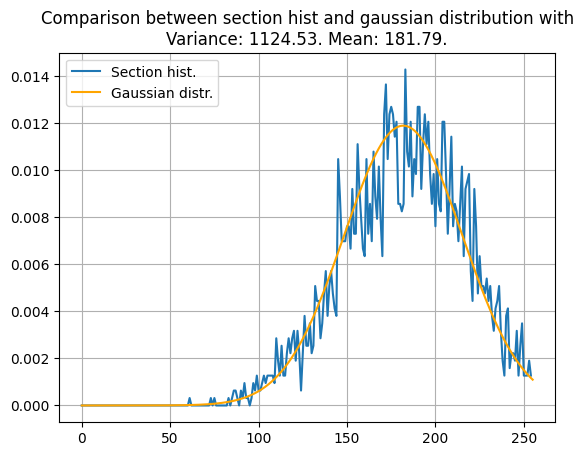

Variance: 1124.53. Mean: 181.79.


In [6]:

variance_mean_value('gr5/Noisy/R8.bmp', 'R8', [255])


- **R30 Image**:

![Descrizione dell'immagine](Histograms/R30_gaussian.png)

In this image, like the previous one we can see a bell shaped histogram. Since the bell is more narrower, we expect the variance to be much lesser than the previous image's variance. 

- Variance: 328.31. 
- Mean: 153.60.

After calculating and comparing the histogram with the gaussian distribution we can conclude that the noise type for this image is also **gaussian**

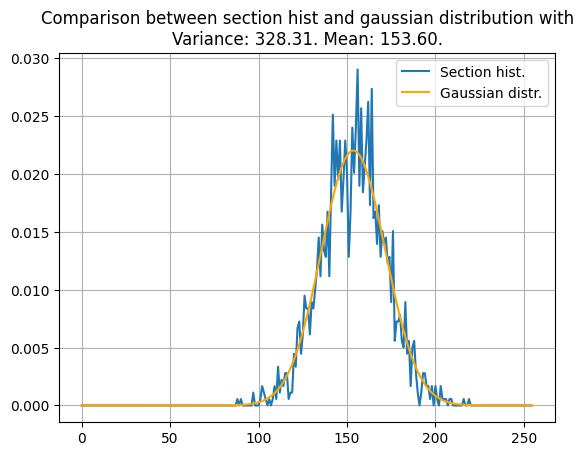

Variance: 328.31. Mean: 153.60.


In [7]:
variance_mean_value('gr5/Noisy/R30.bmp', 'R30', [255])

- **R34 Image**

![Descrizione dell'immagine](Histograms/R34_gaussian.png)

Observing the R34 image we can clearly see it's not affected by a salt&pepper noise. Analyzing the histogram of the captured section, we can see the classic bell shape previously seen on the other two images. Excluding the 255 limit value since it causes trouble with our analysis, we can compute the mean and variance of this histogram and compare it with the gaussian distribution. 

- Variance: 1626.44. 
- Mean: 171.04.

This allow us to conclude that the image is afflicted by **gaussian noise**.

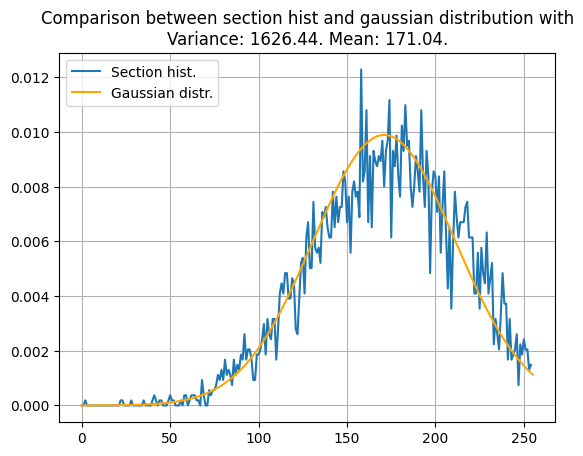

Variance: 1626.44. Mean: 171.04.


In [8]:
variance_mean_value('gr5/Noisy/R34.bmp', 'R34', [255])

- **R39 Image**

![Descrizione dell'immagine](Histograms/R39_gaussian.png)

This image has the classic bell shaped histogram. We can calculate mean and variance and compare the gaussian distribution to the histogram, seeing that they are almost equals.

- Variance: 1438.47 
- Mean: 189.38

We can conclude that the noise which affect the image is **gaussian**


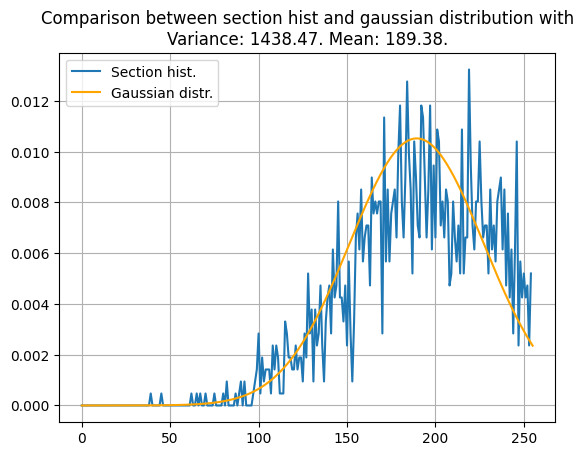

Variance: 1438.47. Mean: 189.38.


In [9]:
variance_mean_value('gr5/Noisy/R39.bmp', 'R39', [255])

- **R51 Image**

![Descrizione dell'immagine](Histograms/R51_salepepe.png)

This image is clearly afflicted by **salt&pepper** noise. We can calculate the density probability of the two extremes.

- Density Probability of pepper (0) noise: 0.0050
- Density Probability of salt (255) noise: 0.0052

After we have calculated the density probability, we can see that they are almost the same, with the probability of salt (255) is a bit more, telling us that the presence of salt noise is a bit more probable than the presence of pepper noise.

Density Probability of pepper (0) noise: 0.0050
Density Probability of salt (255) noise: 0.0052


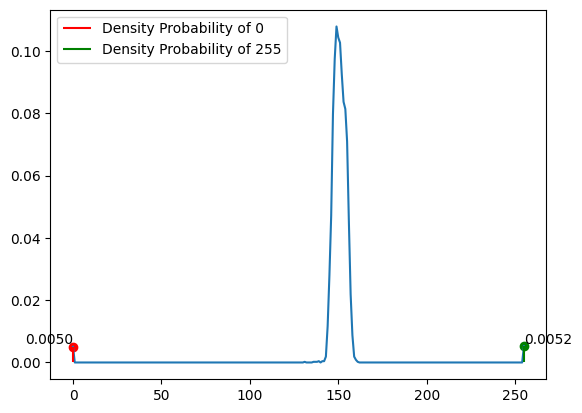

In [10]:
density_probability_salt_pepper("gr5/Noisy/R51.bmp", 'R51')

- **R67 Image**

![Descrizione dell'immagine](Histograms/R67_salepepe.png)

The R67 Image is also clearly **salt&pepper** noise. We can calculate the density probability from the normalized histogram. 

- Density Probability of pepper (0) noise: 0.0299
- Density Probability of salt (255) noise: 0.0199

After the calculus we see that the pepper noise is a lot more probable than the salt noise, which reflect the observations on the image

Density Probability of pepper (0) noise: 0.0299
Density Probability of salt (255) noise: 0.0199


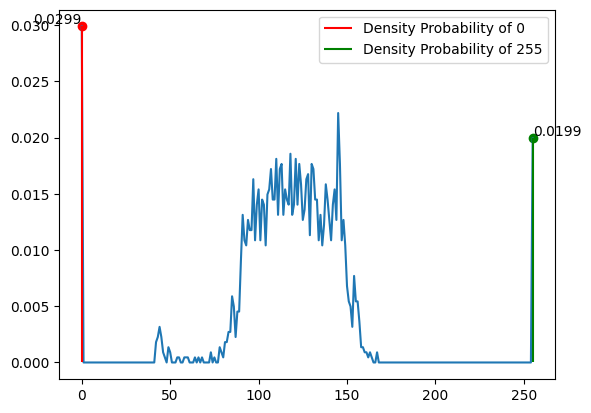

In [11]:
density_probability_salt_pepper("gr5/Noisy/R67.bmp", 'R67')

- **R84 Image**

![Descrizione dell'immagine](Histograms/R84_salepepe.png)

The R84 image is also affected by salt and pepper noise. We proceed to calculate the density probability of black and white noise.

- Density Probability of pepper (0) noise: 0.1014
- Density Probability of salt (255) noise: 0.1003

These densities tells us that the two type of noise have the same probability to show.

Density Probability of pepper (0) noise: 0.1014
Density Probability of salt (255) noise: 0.1003


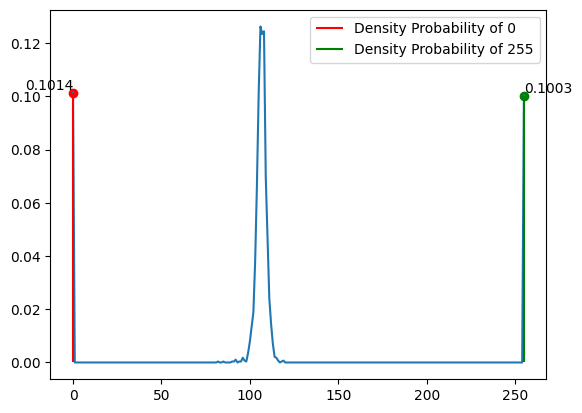

In [12]:
density_probability_salt_pepper("gr5/Noisy/R84.bmp", 'R84')

- **R85 Image**

![Descrizione dell'immagine](Histograms/R85_salepepe.png)

The R84 image has salt and pepper noise. We calculate density probabilities for black and white noise.

- Density Probability of pepper (0) noise: 0.0965
- Density Probability of salt (255) noise: 0.0968

These probabilities indicate equal likelihood for both types of noise.

Density Probability of pepper (0) noise: 0.0965
Density Probability of salt (255) noise: 0.0968


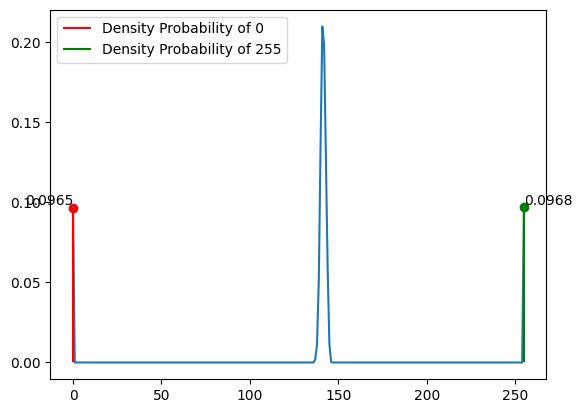

In [13]:
density_probability_salt_pepper("gr5/Noisy/R85.bmp", 'R85')

- **R95 Image**

![Descrizione dell'immagine](Histograms/R95_poisson.png)

Based on the histogram displaying a Poisson distribution, it can be inferred that the presence of Poisson noise is evident in the image R95. 
The characteristics of the histogram indicate that the noise follows a Poisson distribution, which suggests that the image is affected by Poisson noise.

- Variance: 62.97
- Mean: 33.54.

Comparing the graph with the gaussian distribution, we can clearly see it's not a gaussian distribution. Also the right side of the shape is decreasing more rapidly than the left side increasing.

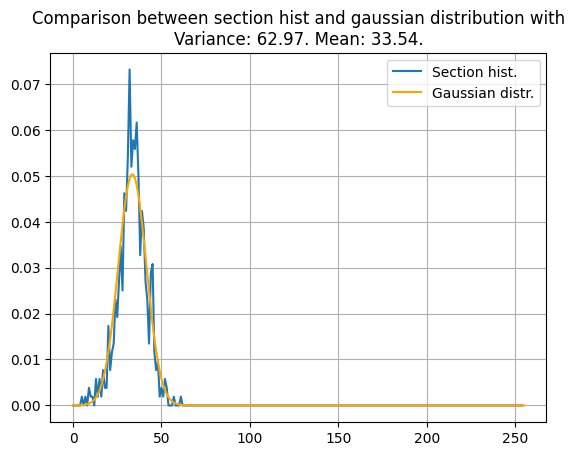

Variance: 62.97. Mean: 33.54.


In [14]:
variance_mean_value("gr5/Noisy/R95.bmp", 'R95', [255])

- **R101 Image**

![Descrizione dell'immagine](Histograms/R101_poisson.png)

This image is also afflicted by Poisson noise, clearly visible by the histogram. It's mean and variance are:

- Variance: 209.22 
- Mean: 191.17.

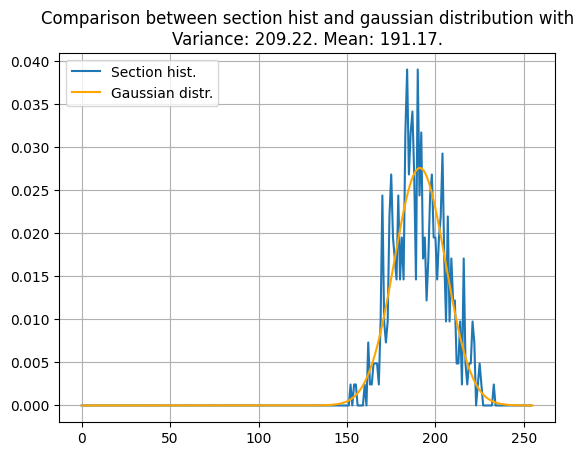

Variance: 209.22. Mean: 191.17.


In [15]:
variance_mean_value("gr5/Noisy/R101.bmp", 'R101', [255])


##### **Task 2**: Noise Reduction
Noise reduction is a fundamental process in image processing to improve visual quality and preserve important details. Two common approaches to reduce noise are using Gaussian filters and median filters.

Gaussian filters are based on the Gaussian distribution and work by convolving the image with a Gaussian kernel. This type of filter tends to slightly blur the image but effectively reduces noise. Gaussian filters are often used to reduce Gaussian noise, which is characterized by a Gaussian distribution of pixel values.

On the other hand, median filters are based on the median of pixel values within a specific window. This type of filter is particularly effective in reducing impulsive or spike noise, such as salt-and-pepper noise. The median allows for the removal of outliers and better preservation of image details compared to other filters.

**Creation of a Gaussian Filter**

The Gaussian filter is a type of filter that applies a Gaussian distribution to an image through convolution.

To create a Gaussian filter, we first apply the Gaussian formula including the required values of sigma and the size of our mask. This is implemented through the functions *gauss*, which returns the Gaussian function given sigma and x dimensions, and *createMask*, which returns the mask with the required values given the mask dimensions and sigma. At this point, the *gaussianFilter* function, which takes the image, mask size, and sigma as input, applies the filter through a 2D convolution.



In [16]:
#Gaussian filter
def gauss(sigma,x):
    ''' 
    Input: 
            sigma: standard deviation for the gauss distribution
                x: mean value for the gauss distribution

    Output: 
            Gauss function given sigma and x
    '''
    gauss = 1/(np.sqrt(2*np.pi)*sigma)*np.e**(-(x**2/(2*sigma**2)))
    return gauss

def createMask(maskSize, sigma):
    ''' 
    Input: 
            maskSize: Dimension for the mask 
            sigma: standard deviation of gauss distribution

    Output: 
            Mask 
    '''
    mask = np.zeros([maskSize + 1, maskSize +1], dtype = float)
    centre = int(maskSize / 2) + 1
    for i in range(1, maskSize +1):
        for j in range(1, maskSize +1):
            dist = np.sqrt(np.power(abs(i-centre),2)+np.power(abs(j-centre),2))
            mask[i][j] = gauss(sigma, dist)
    return mask

# function to apply gaussian filter on a noisy image
def gaussianFilter(noisy_image, maskSize = 3, sigma = 15):
    mask = createMask(maskSize, sigma)
    conv=cv2.filter2D(noisy_image, ddepth=-1, kernel=mask)
    #plt.figure()
    #plt.imshow(conv,cmap="gray")
    return conv

**Creation of a Median Filter**

The median filter is a filter that, by averaging the pixels in the surrounding area and the pixel under consideration, reduces impulsive noise or other irregular noise patterns.

The median filter is simpler to implement than the Gaussian filter, as it takes portions of the image of the kernel size and, after vectorizing the portion, calculates the median and puts it in the reconstructed image at the i-j-th position.

In [17]:
def medianFilter(noisy_image , maskSize = 3):
    
    m, n = np.shape(noisy_image)
    median = np.zeros_like(noisy_image)
    for i in range(1,m-1):
      for j in range (1,n-1):
         l = noisy_image[i:i + maskSize, j:j + maskSize].ravel()
         median[i,j] = np.mean(l)
    #plt.figure()
    #plt.imshow(median,cmap="gray")
    return median

**Denoising the images**

As seen in the task 1, we can classify the images by the affected noise.

- Gaussian Noise: R8, R30, R34, R39
- Poisson Noise: R95, R101
- Salt and Pepper Noise: R51, R67, R84, R85

As requested by the assignment, we have used spatial filtering for each of the images in the following order:

- Gaussian filter used for gaussian noise and Poisson noise
- Median filter used for salt and pepper noise.

The denoised images can be found on the folder *denoised_with_spatial_filters*

##### **Task 3**: Denoising using MRF

As requested by the assignment, we will use MRF to denoise gray scale images. This tecnique is a powerful method to reduce noise and enhance image quality.
The MRF model consider the relationship between neighboring pixels and taking the assumption that nearby pixels are likely to have similar values. 
By modeling an image as a MRF, we can capture the dependencies between the pixels and possibly exploit the outliers pixels representing the noise.

To denoise the images we will implement a particular submethod for denoising using MRF called ICM (Iterative Conditional Modes). This method proceed to denoise the image calculating the energy of the pixels compared to the original noise image and the pixels neighbors. At each iteration, for each pixel on the image we compute the energy of the pixel and check if varying the pixel value we will receive a lower energy. If a lower energy is discovered we proceed to substitute the pixel with the new one.

The core of this method is that the noise tends to break the coherence between the neighbors pixels. So a high presence of noise will determine a much higher energy than a less noisy image.

The algorithm  terminates when there are no more iterations left or a new lower energy cannot be found.

Since the energy can be found only if we give an energy function, we have to distinguish two energy functions:

- energy function for binary images
- energy function for gray scale images

**Energy function for binary images**

The energy function for **binary images** is described by the following formula:

$$ E_{\text{TOT}}(i,j) = E_D(i,j) + E_P(i,j) $$

- $E_{\text{TOT}}$ is the total energy of the pixel. 
- $E_D$ is the energy of the current pixel compared to the original noisy image.
- $E_P$ is the energy of the current pixel compared to his neighbors.

$$E_D(i,j) = w\delta (f(i,j), d(i,j)) $$ 

- $w$ is a parameter that gives more or less weight to the current pixels compared to the original image than its neighbors.
- $f(i,j)$ is the denoised pixel at the current iteration.
- $d(i,j)$ is the original noisy pixel.

$$E_P(i,j) = s ( \delta (f(i,j), f(i+1,j)) + \delta (f(i,j), f(i-1,j)) + \delta (f(i,j), f(i,j-1)) + \delta (f(i,j), f(i,j+1)) ) $$

- $s$ is a parameter that gives more or less weight to the neighbors than the current pixel.
- $f(i+1,j)$ is the lower neighbor of the pixel $f(i,j)$
- $f(i-1,j)$ is the upper neighbor of the pixel.
- $f(i, j-1)$ is the left neighbor of the pixel.
- $f(i, j+1)$ is the right neighbor of the pixel.

$$ \delta (a, b) = \begin{cases} 0  \quad \text{if} \quad a==b \\ 1 \quad \text{otherwise} \end{cases} $$

In [18]:
def delta(a, b):
    return 0 if a==b else 1

def computeLocal(noisy, image, x, y):
    '''
        This method compute the total energy of a pixel and compare this energy
        with the energy if the pixel is inverted. Then returns a boolean saying
        if the inverted pixel has a lower energy.

        args:
            noisy: original noisy image
            image: current denoised image
            x: x-coordinate of the current pixel
            y: y-coordinate of the current pixel

        returns:
            bool: True if lower energy is found, false otherwise
    '''

    x = x+1
    y = y+1

    padded_image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_REPLICATE)

    original_data_term = delta(noisy[x,y], padded_image[x,y])
    inverted_data_term = delta(noisy[x,y], 255 - padded_image[x,y])

    original_penalty_term = (   
                                # compute the penalty term from the upper neighbor
                                delta(padded_image[x,y], padded_image[x-1, y]) + 
                                # compute the penalty term from the lower neighbor
                                delta(padded_image[x,y], padded_image[x+1, y]) +
                                # compute the penalty term from the left neighbor
                                delta(padded_image[x,y], padded_image[x, y-1]) +
                                # compute the penalty term from the right neighbor
                                delta(padded_image[x,y], padded_image[x, y+1])
                            )

    inverted_penalty_term = (   
                                # compute the penalty term of the inverted pixel from the upper neighbor
                                delta(255 - padded_image[x,y], padded_image[x-1, y]) + 
                                # compute the penalty term of the inverted pixel from the lower neighbor
                                delta(255 - padded_image[x,y], padded_image[x+1, y]) +
                                # compute the penalty term of the inverted pixel from the left neighbor
                                delta(255 - padded_image[x,y], padded_image[x, y-1]) +
                                # compute the penalty term of the inverted pixel from the right neighbor
                                delta(255 - padded_image[x,y], padded_image[x, y+1])
                            )
    
    total_original_energy = original_data_term + original_penalty_term
    total_inverted_energy = inverted_data_term + inverted_penalty_term

    return total_inverted_energy < total_original_energy


def MRF_ICM_binary(noisy_image, max_iterations=10):

    # put as denosied image the original image and apply the algorithm to that
    denoised_image = noisy_image.copy()

    current_iteration = 1
    energy_changed = True

    #while lower energy is found and there are iterations left
    while energy_changed and current_iteration <= max_iterations:

        print(f"Iteration {current_iteration} started")

        # suppose no lower energy is found
        energy_changed = False

        # for each pixel on the image
        for i, j in itertools.product(range(0, noisy_image.shape[0]-1), range(0, noisy_image.shape[1]-1)):

                # see if the inverted pixel produces a lower energy than the actual one
                invert_pixel = computeLocal(noisy_image, denoised_image, i, j)

                # if lower energy is found, invert the pixel
                if invert_pixel:

                    denoised_image[i,j] = 255 - denoised_image[i,j]
                    energy_changed = True
        
        # after elaborating all the pixels, go to the next iteration
        current_iteration += 1

    print(f"Algorithm finished at iteration {current_iteration}")   

    return denoised_image

#noisy_image = cv2.imread("gr5/Binary/testImage2.bmp", cv2.IMREAD_GRAYSCALE)
#denoised_image = MRF_ICM_binary(noisy_image)
#psnr = cv2.PSNR(noisy_image, denoised_image)

#print(f"Noise-To-Denoised PSNR: {psnr:.4f}")

#cv2.imshow("noisy image", noisy_image)
#cv2.imshow("denoised image", denoised_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

**Energy function for gray scale images**

The energy function for gray scale images is different than the one for the binary images because we just can't invert the pixel, but we have to test all the gray scale to find the tonality that gives us the minimum energy. In this implementation we chosed to use a quadratic function as energy function.

The energy function for **gray scale images** is described by the following formula:

$$ E_{\text{TOT}}(i,j) = E_D(i,j) + E_P(i,j) $$

- $E_{\text{TOT}}$ is the total energy of the pixel. 
- $E_D$ is the energy of the current pixel compared to the original noisy image.
- $E_P$ is the energy of the current pixel compared to his neighbors.


$$E_D(i,j) = \frac{(g(i,j) - d(i,j))^2}{2 \cdot \sigma^2} $$ 

- $g(i,j)$ is the shade of gray we want to test out.
- $d(i,j)$ is the original noisy pixel intensity value.
- $\sigma^2$ is a parameter used as a weight for the elaborated pixel.

$$E_P(i,j) = \beta \cdot ( [g(i,j) - f(i+1,j)]^2 + [g(i,j) - f(i-1,j)]^2 + [g(i,j) - f(i,j-1)]^2 + [g(i,j) - f(i,j+1)]^2) $$

- $\beta$ is a parameter that gives more or less weight to the neighbors than the current pixel.
- $g(i,j)$ is the shade of gray we want to test out.
- $f(i+1,j)$ is the lower neighbor of the pixel $(i,j)$
- $f(i-1,j)$ is the upper neighbor of the pixel.
- $f(i, j-1)$ is the left neighbor of the pixel.
- $f(i, j+1)$ is the right neighbor of the pixel.


Now that we have decided our energy function we have to implement the MRF. The main problem of this implementation is that to find the minimum energy of each pixel we have to calculate the energy with all the 256 gray levels. In pratice, for an image $512 \times 512$  we should evaluate:

$$ 256 \cdot 512 \cdot 512 = 67.108.864 \quad \text{energy levels}$$ 

Each energy level consists of:

- $5$ differences
- $4$ sums
- $8$ products
- $1$ division 

For semplicity we consider each operation as equal to the others. In this case we have a total of $18$ operations for an energy level. This implies that for a $512 \times 512$ image we must calculate a total of:

$$ 67.108.864 \cdot 18 = 1.207.959.552 \quad \text{operations} $$

for only 1 iteration of the algorithm. This algorithm as explained is too resource & time heavy. Each iteration takes up to 15 minutes. 
We must find a way to reduce it's computational time. During this period we found various possible implementations:

1. Binary search for the minimum gray energy.
2. Derivative-based method.
3. Convolutional-derivative based method.
4. Naive convolutional method


**Binary search**

This method implies that since the gray levels are ordered from 0 to 255 and the energy function is a quadratic function, we can find a global minima by using a binary search with the gray values. We start from a list of ordered gray levels and chose the middle gray. Then we calculate the energy of this gray and if this is lower, we block this gray level as our right limit list, otherwise we block this gray as our left limit list. Then we proceed to take a new middle gray and proceed the same. The research finish when our right limit list is equal to our left limit list, to the minimum gray.

In [19]:
def find_minimum_energy(energy_func, noisy_pixel, neighbors, beta, sigma2):

    left = 0
    right = 255

    # since our energy function is a quadratic function, we expect to find a minimum.
    # the gray scale levels are ordered levels from 0 (black) to 255 (pure white).
    # we can find the minimum where the binary search limits converge.
    while left < right:

        # at first iteration we take the middle gray level between 0 an 255
        mid = (left + right) // 2
        # we calculate the energy level of this gray
        energy_mid = energy_func(noisy_pixel, mid, neighbors, beta, sigma2)
        # and the energy level of the next gray level
        energy_mid_plus_one = energy_func(noisy_pixel, mid+1, neighbors, beta, sigma2)

        # if our left energy is lower than the right energy we 
        # continue the research on the left side of the gray levels
        if energy_mid < energy_mid_plus_one:
            right = mid
        # otherwise we search on the right side of the gray levels
        else:
            left = mid + 1
        # we continue till the left = right, so we found the minimum

    return left, energy_mid

def energy_func(noisy_pixel, gray, neighbors, beta, sigma2):

        gray_data_term = float( (noisy_pixel - gray) ** 2 ) / (2.0 * sigma2)

        gray_data_penalty = beta * float(   (neighbors[0] - gray) ** 2 + 
                                            (neighbors[1] - gray) ** 2 + 
                                            (neighbors[2] - gray) ** 2 + 
                                            (neighbors[3] - gray) ** 2
                                        )
        
        gray_total_energy = gray_data_term + gray_data_penalty

        return gray_total_energy


def MRF_ICM_bin_search(noisy_image, max_iterations=10, sigma2=1, beta=0.1):

    print(f"Algorithm started with parameters: sigma2={sigma2}, beta={beta}")
    start_time = time.time()

    denoised_image = noisy_image.copy()

    current_iteration = 1
    energy_changed = True
    
    # while there are iterations left and the energy is still changing
    while current_iteration <= max_iterations and energy_changed:

        energy_changed = False
        print(f"Iteration {current_iteration} started.")
        
        # cycle on every pixel of the image to find a lower energy level
        for i, j in itertools.product(range(0, denoised_image.shape[0]), range(0, denoised_image.shape[1])):

            # get the pixel's neighbors from a padded image to simplify the calculus
            padded_denoised_image = cv2.copyMakeBorder(denoised_image, 1, 1, 1, 1, cv2.BORDER_REFLECT)
            pixel_neighbors =   [ 
                                    # upper neighbor
                                    padded_denoised_image[i-1,j], 
                                    # lower neighbor
                                    padded_denoised_image[i+1, j],
                                    # left neighbor
                                    padded_denoised_image[i, j-1],
                                    # right neighbor
                                    padded_denoised_image[i, j+1]
                                ]

            # find the actual energy of the pixel
            actual_pixel_energy = energy_func(noisy_image[i,j], 0, pixel_neighbors, beta, sigma2)

            # find the gray_level with minimum energy with binary search on gray levels.
            gray_level, gray_energy = find_minimum_energy(energy_func, noisy_image[i,j], pixel_neighbors, beta, sigma2)

            # if the gray_energy is lower than the actual energy of the pixel, substitute the pixel with the new gray level
            if gray_energy < actual_pixel_energy:

                energy_changed = True
                denoised_image[i,j] = gray_level

        # go to the next iteration
        print(f"Iteration {current_iteration} completed.")
        current_iteration += 1

    execution_time = time.time() - start_time

    return denoised_image, execution_time

**Derivative-based method** (discovered by Davide Sferrazza)

This method is based on a deterministic solution. As we previously said, the energy function is a quadratic function so we are sure that there is a global minima. This minima can be found by differentiate the energy function with respect to $x$ where $x$ is our unknown gray level, then put the derivative equals to $0$.

Let's call our total energy function of the pixel $E_{\text{TOT}} = f(x)$, then our $f(x) can be written as:

$$ f(x) = \frac{(x - d)^2}{2 \sigma^2} + \beta \sum_{i=1}^N (x - \lambda_i)^2 $$

- $x$ is our unknown gray value
- $d$ is the original noisy pixel in our current position $(i,j)$
- $\sigma^2$ is the previously explained parameter.
- $\beta$ is the previously explained parameter.
- $N$ is the number of neighbors.
- $\lambda_i$ is the i-th neighbor

The derivative of $f(x)$ is:

$$\frac{d}{dx} f(x) = - \frac{(x-d)}{\sigma^2} - 2 \beta \sum_{i=1}^N (x - \lambda_i)$$

Since we use 4-Neighbors we can expand the sum as:

$$ \sum_{i=1}^4 (x - \lambda_i) = (x - \lambda_1) + (x - \lambda_2) + (x - \lambda_3) + (x - \lambda_4) = 4x - (\lambda_1 + \lambda_2 + \lambda_3 + \lambda_4) $$

We define the sum of the neighbors as $s$:

$$ s = (\lambda_1 + \lambda_2 + \lambda_3 + \lambda_4) $$

To find the minimum we must put the derivative equals to 0:

$$\frac{d}{dx} f(x) = 0 \Rightarrow \frac{(x-d)}{\sigma^2} + 8 \beta x - 2 \beta s = 0$$

This equation gives us the gray with minimum energy:

$$ x = \frac{d + 2\beta \sigma^2 s}{1 + 8 \beta \sigma^2} $$

So, with this new formula we don't need anymore to test out all the 255 shades of gray, we instantly new which gray has the lower energy.

In [20]:
def MRF_ICM_derivative(noisy_image, max_iterations=10, sigma2=1, beta=1):

    print(f"Algorithm started with parameters: sigma2={sigma2}, beta={beta}")
    start_time = time.time()

    denoised_image = noisy_image.copy()

    energy_changed = True
    current_iteration = 1

    # while there are iterations left and the energy is still changing
    while current_iteration <= max_iterations and energy_changed:

        energy_changed = False
        print(f"Iteration {current_iteration} processing...")
        
        # cycle on every pixel of the image to find a lower energy level
        for i, j in itertools.product(range(0, denoised_image.shape[0]), range(0, denoised_image.shape[1])):

            # get the pixel's neighbors from a padded image to simplify the calculus
            padded_denoised_image = cv2.copyMakeBorder(denoised_image, 1, 1, 1, 1, cv2.BORDER_REFLECT)
            pixel_neighbors =   [ 
                                    # upper neighbor
                                    padded_denoised_image[i-1,j], 
                                    # lower neighbor
                                    padded_denoised_image[i+1, j],
                                    # left neighbor
                                    padded_denoised_image[i, j-1],
                                    # right neighbor
                                    padded_denoised_image[i, j+1]
                                ]

            # find the actual energy of the pixel
            # the energy function is the same of the binary_search one
            actual_pixel_energy = energy_func(noisy_image[i,j], 0, pixel_neighbors, beta, sigma2)

            # find the gray level with minimum energy utilizing the derivative method
            gray_with_min_energy = np.round((noisy_image[i,j] + (2 * beta * sigma2 * sum(pixel_neighbors))) / ( 1 + (8 * beta * sigma2)))

            # find the new energy relative to the new gray level
            gray_energy = energy_func(noisy_image[i,j], gray_with_min_energy, pixel_neighbors, beta, sigma2)

            # if the new gray energy found is lower than the actual one, substitute the pixel with the new gray level
            if gray_energy < actual_pixel_energy:

                denoised_image[i,j] = gray_with_min_energy
                energy_changed = True
 
        # go to the next iteration
        print(f"Iteration {current_iteration} completed.", flush=True)
        current_iteration +=1
    
    execution_time = time.time() - start_time

    return denoised_image, execution_time

**convolutional-derivative based method**

This method is a bit particular since it does not update pixel by pixel with the gray with minimum energy. In fact it calculate for each pixel the minimum energy gray level and update all of them simultaneously. In the previous method, a pixel find his minimum energy by his neighbors, which were calculated before the current pixel, so the elaboration was taking count of an updated pixel when passing to the next. In this method the updated neighbors are available only on the next iteration. The gray with minimum energy is still calculated by the derivative method.

In [21]:
def computeEnergyTerms(noisy_image, denoised_image, lower_energy_gray):

    data_term_matrix = (noisy_image - lower_energy_gray) ** 2

    # we use padding to facilitate the calculus with neighbors
    padded_denoised_image = cv2.copyMakeBorder(denoised_image, 1, 1, 1, 1, cv2.BORDER_REFLECT)

    # the penalty matrix is computed by utilizing the 4 neighbors
    data_penalty_matrix =   ( 
                                # computing the upper neighbor
                                (lower_energy_gray - padded_denoised_image[:-2, 1:-1]  ) ** 2 + 
                                # computing the lower neighbor
                                (lower_energy_gray - padded_denoised_image[2:, 1:-1]   ) ** 2 +
                                # computing the left neighbor
                                (lower_energy_gray - padded_denoised_image[1:-1, :-2]  ) ** 2 +
                                # computing the right neighbor
                                (lower_energy_gray - padded_denoised_image[1:-1, 2:]   ) ** 2
                            )
    

    return data_term_matrix, data_penalty_matrix

def MRF_ICM_conv_derivative(noisy_image, max_iterations=10, sigma2=1, beta=1):

    start_time = time.time()

    kernel = np.array([ [0, 1, 0], [1, 0, 1], [0, 1, 0] ])

    denoised_image = noisy_image.copy().astype(np.float32)

    current_iteration = 1

    energy_changed = True

    while energy_changed and current_iteration <= max_iterations:
            
            #reset energy_changed flag
            energy_changed = False

            # energy terms for actual energy matrix
            data_term_matrix, data_penalty_matrix = computeEnergyTerms(noisy_image, denoised_image, denoised_image)

            # actual energy matrix
            total_energy_matrix =  ( data_term_matrix / (2 * sigma2) ) + beta * (data_penalty_matrix)

            # new image with lower level energy gray for each cell
            lower_gray_image = np.round(( noisy_image + 2 * beta * sigma2 * cv2.filter2D(denoised_image, -1, kernel) ) / ( 1 + 8 * beta * sigma2))

            # elaborate the new energy levels
            lower_data_term_matrix, lower_data_penalty_matrix = computeEnergyTerms(noisy_image, denoised_image, lower_gray_image)

            # new (possibly) lower energy matrix
            lower_energy_matrix = ( lower_data_term_matrix / (2 * sigma2) ) + beta * (lower_data_penalty_matrix)

            # create a new matrix with the new minimum energy values
            result_energy = np.minimum(total_energy_matrix, lower_energy_matrix)

            # check each cell and see if something changed
            has_changed = (total_energy_matrix != result_energy)

            if has_changed.any():
                 
                # change the value on each cell with lower energy gray
                denoised_image = np.where(has_changed, lower_gray_image, denoised_image)
                energy_changed = True

            current_iteration +=1

    denoised_image = denoised_image.astype(np.uint8)

    total_time = time.time() - start_time

    return denoised_image, total_time

We can compare the time every algorithm takes to elaborate the same image and compare the PSNR's, paying attention to the last algorithm since it works a bit differently.

<img src="DenoisedMRF/comparison/comparison.png" alt="Descrizione dell'immagine" width="1500">
<center>
    <img src="DenoisedMRF/comparison/time_comparison.png" alt="Descrizione dell'immagine" width="500">
</center>

N.B. All the images denoised stored in the folder DenoisedMRF/ were denoised with $\sigma^2 = 0.3$ and $\beta = 1.5$

By the time and PSNR comparison we can quickly see that the the derivative method is faster than the binary search and provides the exact same results. The convolutional derivative method produces a different image for the motivations explained above. For the convolutional derivative method is usually required to use a lot more iterations (minimum 50-100) too see a major difference. Still, even with more iterations, the convolutional derivative  is the fastest, almost instant method.

In [22]:
def showImageComparison(original_image, noisy_image, denoised_binary_search, denoised_derivative, denoised_convolutional):

    psnr_noisy_original = cv2.PSNR(noisy_image, original_image)
    mse_noisy_original = np.mean((original_image - noisy_image)**2)

    psnr_noisy_binary = cv2.PSNR(noisy_image, denoised_binary_search)
    psnr_noisy_derivative = cv2.PSNR(noisy_image, denoised_derivative)
    psnr_noisy_conv = cv2.PSNR(noisy_image, denoised_convolutional)

    mse_noisy_binary = np.mean((denoised_binary_search - noisy_image)**2)
    mse_noisy_derivative = np.mean((denoised_derivative - noisy_image)**2)
    mse_noisy_conv = np.mean((denoised_convolutional - noisy_image)**2)

    # Crea una figura con tre subplots
    fig, axs = plt.subplots(1, 4, figsize=(10, 4))
    # Mostra le immagini nei subplots
    axs[0].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('noisy original')
    axs[0].set_xlabel(f'MSE[Noisy-Original]: {mse_noisy_original:.2f}\nPSNR[Noisy-Original]: {psnr_noisy_original:.2f}db', visible=True)

    axs[1].imshow(cv2.cvtColor(denoised_binary_search, cv2.COLOR_BGR2RGB))
    axs[1].set_title('den. with binary search')
    axs[1].set_xlabel(f'MSE[Noisy-Denoised]: {mse_noisy_binary:.2f}\nPSNR[Noisy-Denoised]: {psnr_noisy_binary:.2f}db', visible=True)

    axs[2].imshow(cv2.cvtColor(denoised_derivative, cv2.COLOR_BGR2RGB))
    axs[2].set_title('den. with derivative method')
    axs[2].set_xlabel(f'MSE[Noisy-Denoised]: {mse_noisy_derivative:.2f}\nPSNR[Noisy-Denoised]: {psnr_noisy_derivative:.2f}db', visible=True)

    axs[3].imshow(cv2.cvtColor(denoised_convolutional, cv2.COLOR_BGR2RGB))
    axs[3].set_title('den. with conv-deriv. method')
    axs[3].set_xlabel(f'MSE[Noisy-Denoised]: {mse_noisy_conv:.2f}\nPSNR[Noisy-Denoised]: {psnr_noisy_conv:.2f}db', visible=True)

    # Impostazione delle dimensioni della figura per occupare tutto lo spazio orizzontale del notebook
    fig.set_size_inches(15, 8)
    # Regola lo spaziamento tra i subplots
    plt.subplots_adjust(wspace=1)
    # Mostra il grafico
    plt.show()

def showTimeComparison(binary_execution_time, derivative_execution_time, convolutional_execution_time):

    # Times
    times = [binary_execution_time, derivative_execution_time, convolutional_execution_time]
    # Methods labels
    labels = ["Binary search", "Derivative Method", "Convolution Derivative"]
    # Positions on X axis
    positions = np.arange(len(labels))
    # Bar Graph
    plt.bar(positions, times)
    plt.ylabel('Time (seconds)')
    plt.title('Execution time (10 Iterations, sigma2=1, beta=1)')
    plt.xticks(positions, labels)

    for i in range(len(times)):
        plt.text(i, times[i], "{:.4f} secs".format(times[i]), ha='center', va='bottom')

    plt.show()


original_image = cv2.imread("gr5/Original/R8.bmp", cv2.IMREAD_GRAYSCALE)
noisy_image = cv2.imread("gr5/Noisy/R8.bmp", cv2.IMREAD_GRAYSCALE)

#denoised_binary_search, binary_execution_time = MRF_ICM_bin_search(noisy_image, max_iterations=10, sigma2=1, beta=1)
#denoised_derivative, derivative_execution_time = MRF_ICM_derivative(noisy_image, max_iterations=10, sigma2=1, beta=1)
#denoised_convolutional, convolutional_execution_time = MRF_ICM_conv_derivative(noisy_image, max_iterations=10, sigma2=1, beta=1)

#showImageComparison(original_image, noisy_image, denoised_binary_search, denoised_derivative, denoised_convolutional)
#showTimeComparison(binary_execution_time, derivative_execution_time, convolutional_execution_time)



**Naive convolutional method**

This particular implementation utilizes convolution to calculate the penalties associated with each pixel. This approach enables the computation of pixel penalties in a single operation, eliminating the need of loops. The operation is applied to all color intensities in the channel (in this case, grayscale), resulting in a three-dimensional array with dimensions of $256 \times H \times W$. For each combination of height and width position, the minimum value needs to be determined. To enhance performance, a future implementation could involve a C-written function, as the current implementation relies heavily on nested loops.

- The energy matrix of the data and the penalty energy matrix are then added together according to the algorithm.
- The *denoiseImage* function takes the image, a weight for the penalties, and an exponent for the matrix as input.
- A copy of the image, an intensity array, and a mask are then created. The mask is then multiplied by WEp (Weight Energy Penalty).
- For each of the grayscale intensities, a plane of a three-dimensional matrix is created, proposing the current intensity. 
- Once all the proposals are collected, the best energy of each pixel is chosen.


In [ ]:
def denoiseImage(X, WEp=0.25, exp=0.9):
  ''' 
  args: 
        X: noisy image shaped as np array. 
        WEp: weight for data penalty.
        exp: exponent for penalty matrix.

  output: Denoised image
  '''
  #Creating a working copy of the image
  Y = np.copy(X)
  
  #Mask for the 2D conv
  mask = np.array([[0,1,0],[1,0,1],[0,1,0]])
  mask = mask * WEp

  energyMatrix = []
  #In this loop, we collect the energy functions for each gray level, and the gray shade is preserved in the index of the generated array.
  for i in range(256):
    matrix = Y-i
    conv = cv2.filter2D(matrix, ddepth=-1, kernel=mask)
    tryIntensityEp = conv
    tryIntensityEp = np.power(tryIntensityEp,exp)
    tryIntensityEd = matrix**2
    sum = tryIntensityEp + tryIntensityEd
    energyMatrix.append(sum)
  
  energyMatrix = np.asarray(energyMatrix)
   
  #Given the augmented array WxHx256, we need to find, for each combination of W and H, the index of the minimum energy.
  #This loop is the most expensive part of the process, and an optimization could be to implement the function in C.
  x,y,z = np.shape(energyMatrix)
  for i in range(y):
    for j in range(z):
      Y[i,j] = np.argmin(energyMatrix[:,i,j])
      #Possible optimization: write a function that takes the energy matrix and divides it by the number of processors and then performs multiprocessing.
  
  #Free the memory.
  energyMatrix=[]
  
  return Y.astype(dtype=np.uint8)


original_image = cv2.imread("gr5/Original/R8.bmp", cv2.IMREAD_GRAYSCALE)
noisy_image = cv2.imread("gr5/Noisy/R8.bmp", cv2.IMREAD_GRAYSCALE)

#denoised_image = denoiseImage(noisy_image, 0.25, 0.1)

#cv2.imshow("Noisy", noisy_image)
#cv2.imshow("Denoised", denoised_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#cv2.waitKey(1)